In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import csv
import sys
import numpy as np
import base64
import os
import random
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

In [18]:
def getdataloaders(data,train_batch_size=50,test_batch_size=50):
    np.random.shuffle(data.T)
    train_data1 = data[:,:35000]
    test_data1 = data[:,35000:]
    
    #creating train batches
    num_batches_train = int(train_data1.shape[1]/train_batch_size)
    train_data= np.empty([num_batches_train,train_data1.shape[0],train_batch_size])
    for idx in range (0, num_batches_train):
        train_data[idx,:,:]=train_data1[:,idx*train_batch_size:(idx + 1)*train_batch_size]
    
    #creating test batches
    num_batches_test = int(test_data1.shape[1]/test_batch_size)
    test_data =np.empty([num_batches_test,test_data1.shape[0],test_batch_size])
    for idx in range (0, num_batches_test):
        test_data[idx,:,:]=test_data1[:,idx*test_batch_size:(idx + 1)*test_batch_size]
    
    return train_data,test_data

In [19]:
def cal_accuracy(target,output):
    correct_count = 0;
    
    for i in range (0,target.size(0)):
        if(output[i]>0.5):
            result =1 
        else:
            result =0
        if(target[i] == result):
            correct_count += 1
    accuracy = correct_count/target.size(0)
    
    return accuracy,correct_count


def update_conf_mat(conf_mat,target,output):
    # m= nn.Sigmoid()
    # target = m(target)
    for i in range(0,target.size(0)):
        if(output[i] > 0.4):
            result =1 
        else:
            result =0       
        conf_mat[result,int(target[i].cpu())] += 1

    return conf_mat
    

In [20]:
class network(nn.Module):
    def __init__(self,input_nodes,hidden_nodes1,hidden_nodes2,output_node):
        super(network,self).__init__()
        self.fc1 = nn.Linear(input_nodes,hidden_nodes1)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.bn1 = nn.BatchNorm1d(num_features=hidden_nodes1)
        
        self.fc2 = nn.Linear(hidden_nodes1,hidden_nodes2)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.drop = nn.Dropout(0.2)
        self.bn2 = nn.BatchNorm1d(num_features = hidden_nodes2)
        
        self.fc3 = nn.Linear(hidden_nodes2,output_nodes)
        nn.init.xavier_uniform_(self.fc3.weight)
        
        self.out_act = nn.Sigmoid();
        
    def forward(self,X):
        X = F.relu(self.bn1(self.fc1(X)))
        X = self.fc2(X)
        X = self.drop(X)
        X = F.relu(X)
        X = self.fc3(X)
        # out = self.out_act(X)
        return X
        
    

In [9]:
def train(trainloader, optimizer, criterion, epoch, net):
    net.train()
    train_loss_sum = 0
    total_correct_count = 0
    total_accuracy = 0 
    for  idx in range(trainloader.size(0)):
        target = trainloader[idx,47,:].reshape(trainloader.size(2)).float().reshape(trainloader.size(2),1)
        input_vectors = trainloader[idx,:47,:].float().t().cuda()
        output = net.forward(input_vectors)
        loss = criterion(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_sum += float(loss)
        batch_accuracy,batch_corr_count = cal_accuracy(target,output)
        total_accuracy += batch_accuracy
    avg_acc = total_accuracy/trainloader.size(0)
    train_loss = train_loss_sum/trainloader.size(0)
    print("Epoch No." , epoch, " Train Loss" ,train_loss," Avg Accuracy ",avg_acc*100,"%")
    return train_loss


def test(testloader,criterion,epoch,net):
    net.eval()
    conf_matrix = np.zeros((2,2))
    test_loss_sum = 0
    total_correct_count = 0
    total_accuracy = 0 
    for idx in range(testloader.size(0)):
        target = testloader[idx,47,:].reshape(testloader.size(2)).float().reshape(testloader.size(2),1)
        input_vectors = testloader[idx,:47,:].float().t().cuda()
        output = net.forward(input_vectors)
        conf_matrix = update_conf_mat(conf_matrix,target,output)
        loss = criterion(output,target.float())
        test_loss_sum += float(loss)
        batch_accuracy,batch_corr_count = cal_accuracy(target,output)
        total_accuracy += batch_accuracy
    test_loss = test_loss_sum/testloader.size(0)
    avg_acc = total_accuracy/testloader.size(0)
    print("Epoch No." , epoch, " Test Loss" ,test_loss," Avg Accuracy ",avg_acc*100,"%")
    print("Confusion Matrix", conf_matrix)
    print(" ")
    return test_loss
        
        
    

In [10]:
def plot_loss(x,y):
    plt.plot(x,y)
    plt.show()

In [34]:
input_nodes = 47
hidden_nodes1 = 256
hidden_nodes2 = 256
output_nodes = 1
batch_number = 50
learning_rate = 0.001
epochs = 30

data=np.load("../model_data/data_float360_8_cs.npy")
train_data,test_data = getdataloaders(data,10,10)
trainloader = torch.from_numpy(train_data).cuda()
testloader =  torch.from_numpy(test_data).cuda()


reeds_net = network(input_nodes,hidden_nodes1,hidden_nodes2,output_nodes).cuda()
optimizer = torch.optim.Adam(reeds_net.parameters(), lr=learning_rate)
pos_weight = torch.tensor([12]).float().cuda()
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
# criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)


train_loss_list = []
test_loss_list = []
epoch_list = []
for epoch in range(epochs):
    train_loss=train(trainloader, optimizer, criterion, epoch, reeds_net)
    test_loss= test(testloader, criterion, epoch, reeds_net)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    epoch_list.append(epoch)

Epoch No. 0  Train Loss 1.4362053575260298  Avg Accuracy  63.245714285714186 %
Epoch No. 0  Test Loss 1.2247594532743837  Avg Accuracy  70.25844930417487 %
Confusion Matrix [[1028.   29.]
 [1485. 2488.]]
 
Epoch No. 1  Train Loss 1.3240817591803415  Avg Accuracy  66.52285714285703 %
Epoch No. 1  Test Loss 1.2082054869792096  Avg Accuracy  73.12127236580514 %
Confusion Matrix [[1195.   44.]
 [1318. 2473.]]
 
Epoch No. 2  Train Loss 1.2730816038165773  Avg Accuracy  68.07428571428562 %
Epoch No. 2  Test Loss 1.1511046967615428  Avg Accuracy  72.74353876739559 %
Confusion Matrix [[1162.   27.]
 [1351. 2490.]]
 
Epoch No. 3  Train Loss 1.243714627138206  Avg Accuracy  68.59428571428566 %
Epoch No. 3  Test Loss 1.1589033732238867  Avg Accuracy  73.24055666003973 %
Confusion Matrix [[1182.   28.]
 [1331. 2489.]]
 
Epoch No. 4  Train Loss 1.2209666551521847  Avg Accuracy  69.10571428571423 %
Epoch No. 4  Test Loss 1.1444197774940645  Avg Accuracy  73.28031809145126 %
Confusion Matrix [[1191. 

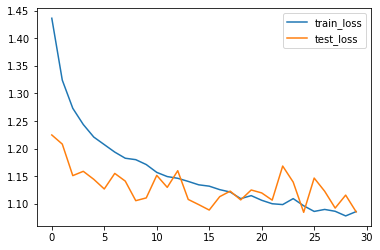

In [35]:
#plotting the losses
plt.plot(epoch_list,train_loss_list)
plt.plot(epoch_list,test_loss_list)
plt.gca().legend(("train_loss","test_loss"))
plt.show()

In [36]:
torch.save(reeds_net.state_dict(),'trained_model/reeds_net360_8_cs.pt')